## STAT5 Dimerization Model

The goal of the notebook is to study practical identifiability of [STAT5 Dimerization](doi:10.1021/pr5006923) Model with *LikelihoodProfiler*. STAT5 Dimerization is one of the Benchmark models for [dMod R package](https://github.com/dkaschek/dMod). We have translated the model to [Julia language](https://julialang.org/). [dMod BenchmarkModels repo](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) contains the model files, experimental data and best-fit parameters.
The model is defined by the following system of differential equations:

In [1]:
using DiffEqBase, CSV, DataFrames, LikelihoodProfiler, LSODA
using Plots

# constants
const cyt = 1.4
const nuc = 0.45
const ratio = 0.693
const specC17 = 0.107


# ode system
function stat5_ode(du, u, p, time)
    # 8 states:
    (STAT5A, pApA, STAT5B, pApB, pBpB, nucpApA, nucpApB, nucpBpB) = u
    # 6 parameters
    (Epo_degradation_BaF3, k_exp_hetero, k_exp_homo, k_imp_hetero, k_imp_homo, k_phos) =  p
    
    BaF3_Epo = 1.25e-7*exp(-1*Epo_degradation_BaF3*time)

    v1 = BaF3_Epo*(STAT5A^2)*k_phos
    v2 = BaF3_Epo*STAT5A*STAT5B*k_phos
    v3 = BaF3_Epo*(STAT5B^2)*k_phos
    v4 = k_imp_homo*pApA
    v5 = k_imp_hetero*pApB
    v6 = k_imp_homo*pBpB
    v7 = k_exp_homo*nucpApA
    v8 = k_exp_hetero*nucpApB
    v9 = k_exp_homo*nucpBpB

    du[1] = -2*v1 - v2 + 2*v7*(nuc/cyt) + v8*(nuc/cyt)
    du[2] = v1 - v4
    du[3] = -v2 -2*v3 + v8*(nuc/cyt) + 2*v9*(nuc/cyt)
    du[4] = v2 - v5
    du[5] = v3 - v6
    du[6] = v4*(cyt/nuc) - v7
    du[7] = v5*(cyt/nuc) - v8
    du[8] = v6*(cyt/nuc) - v9
    end;

Let's load the experimental dataset 

In [2]:
data = CSV.read("data_stat5.csv", DataFrame);

Observables, initial values and solver settings are set according to [model's files](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) and [dMod settings](https://github.com/dkaschek/dMod/blob/master/R/PEtab2dMod.R)

In [3]:
saveat = Float64.(data[!,:time])
tspan = (0.,saveat[end])

u0 = zeros(8)
u0[1] = 207.6*ratio         # STAT5A
u0[3] = 207.6 - 207.6*ratio # STAT5B

prob(p) = ODEProblem(stat5_ode, eltype(p).(u0), tspan, p)

function solve_prob(p)
    _prob = prob(p)

    # solution
    sol = solve(_prob, lsoda(), saveat=saveat, reltol=1e-7,abstol=1e-7) #save_idxs=[1,2,3,4,5] 
    STAT5A = sol[1,:]
    pApA = sol[2,:]
    STAT5B = sol[3,:]
    pApB = sol[4,:]
    pBpB = sol[5,:]

    # observables
    pSTAT5A_rel = (100 * pApB + 200 * pApA * specC17) ./ (pApB + STAT5A * specC17 + 2 * pApA * specC17)
    pSTAT5B_rel = -(100 * pApB - 200 * pBpB * (specC17 - 1)) ./ ((STAT5B * (specC17 - 1) - pApB) + 2 * pBpB * (specC17 - 1))
    rSTAT5A_rel = (100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) ./ (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1))

    return [pSTAT5A_rel, pSTAT5B_rel, rSTAT5A_rel]
end;

The [best-fit](https://github.com/dkaschek/dMod/blob/master/BenchmarkModels/Boehm_JProteomeRes2014/parameters_Boehm_JProteomeRes2014.tsv) parameters values:

In [4]:
p_best = [
    0.026982514033029,      # Epo_degradation_BaF3
    0.0000100067973851508,  # k_exp_hetero
    0.006170228086381,      # k_exp_homo
    0.0163679184468,        # k_imp_hetero
    97749.3794024716,       # k_imp_homo
    15766.5070195731,       # k_phos
    3.85261197844677,       # sd_pSTAT5A_rel
    6.59147818673419,       # sd_pSTAT5B_rel
    3.15271275648527        # sd_rSTAT5A_rel
];

Let's run the simulations and plot results for best-fit parameters values

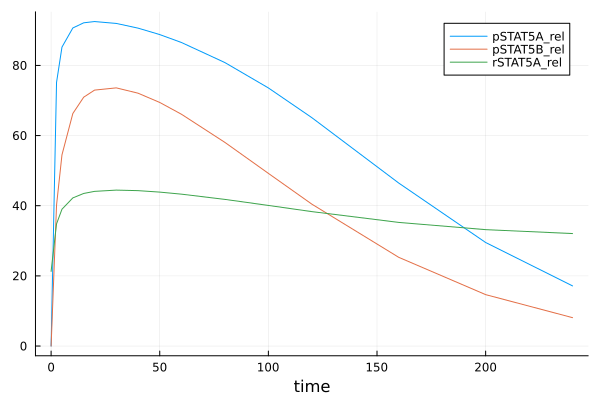

In [5]:
sol = solve_prob(p_best)
plot(saveat, sol, label=["pSTAT5A_rel" "pSTAT5B_rel" "rSTAT5A_rel"], xlabel=:time)

Loss function includes parameters transformation to log10 scale:

In [6]:
function loss_func(p_init)
    p = exp10.(p_init)

    sim = solve_prob(p)
    σ = p[7:9]
    # loss
    return loss(sim,data,σ)
end

function loss(sim,data,σ)
    loss = 0.0
    obs = names(data)[2:end]  

    for i in 1:length(obs)
        loss_i = loss_component(sim[i],data[!,i+1],σ[i])
        loss += loss_i
    end
    return loss
end

function loss_component(sim,data,σ)
    loss_i = 0.0
    
    for i in eachindex(sim)
            loss_i += ((sim[i]-data[i])/σ)^2 + 2*log(sqrt(2π)*σ)
    end
    return loss_i
end;

Now we are ready to perform identifiability analysis with *LikelihoodProfiler*

In [7]:
α = loss_func(log10.(p_best)) + 3.84 # chisq with 1 df

# search CI with LikelihoodProfiler
num_params = length(p_best)

intervals = Vector{ParamInterval}(undef,num_params)
p_log = log10.(p_best)

tbounds = fill((-7.,7.), num_params)
sbounds = (-5.,5.)
for i in 1:num_params
    @time intervals[i] = get_interval(
        p_log,
        i,
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end;

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\evgen\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
right CP counter: 929    Time: 0:00:00 ( 0.34 ms/it)


  0.398476 seconds (1.51 M allocations: 81.322 MiB, 1.32% gc time)


In [8]:
ENV["COLUMNS"]=120
res = DataFrame(
    params = [:Epo_degradation_BaF3,:k_exp_hetero,:k_exp_homo,:k_imp_hetero,:k_imp_homo,:k_phos,:sd_pSTAT5A_rel,:sd_pSTAT5B_rel,:sd_rSTAT5A_rel],
    LSatus = [k.result[1].status for k in intervals],
    UStatus = [k.result[2].status for k in intervals],
    LBound = [k.result[1].value for k in intervals],
    UBound = [k.result[2].value for k in intervals],
    LCount = [k.result[1].counter for k in intervals],
    UCount = [k.result[2].counter for k in intervals],
    InitValues = p_log
)

Row,params,LSatus,UStatus,LBound,UBound,LCount,UCount,InitValues
,Symbol,Symbol,Symbol,Union…,Union…,Int64,Int64,Float64
1,Epo_degradation_BaF3,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,-1.70803,-1.41987,523,494,-1.56892
2,k_exp_hetero,SCAN_BOUND_REACHED,BORDER_FOUND_BY_SCAN_TOL,,-3.14629,4,1036,-4.9997
3,k_exp_homo,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,-2.48322,-1.98024,237,289,-2.2097
4,k_imp_hetero,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,-1.85648,-1.68961,171,179,-1.78601
5,k_imp_homo,BORDER_FOUND_BY_SCAN_TOL,SCAN_BOUND_REACHED,0.190413,,1287,7,4.99011
6,k_phos,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,4.15994,4.27243,143,168,4.19774
7,sd_pSTAT5A_rel,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.43758,0.768413,172,243,0.585755
8,sd_pSTAT5B_rel,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.720768,0.990163,231,186,0.818983
9,sd_rSTAT5A_rel,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.400102,0.666105,204,929,0.498684
